In [1]:
%matplotlib inline


# OT for multi-source target shift


This example introduces a target shift problem with two 2D source and 1 target domain.




In [2]:
# Authors: Remi Flamary <remi.flamary@unice.fr>
#          Ievgen Redko <ievgen.redko@univ-st-etienne.fr>
#
# License: MIT License

import pylab as pl
import numpy as np
import ot
from ot.datasets import make_data_classif

Generate data
-------------



In [3]:
n = 50
sigma = 0.3
np.random.seed(1985)

p1 = .2
dec1 = [0, 2]

p2 = .9
dec2 = [0, -2]

pt = .4
dect = [4, 0]

xs1, ys1 = make_data_classif('2gauss_prop', n, nz=sigma, p=p1, bias=dec1)
xs2, ys2 = make_data_classif('2gauss_prop', n + 1, nz=sigma, p=p2, bias=dec2)
xt, yt = make_data_classif('2gauss_prop', n, nz=sigma, p=pt, bias=dect)

all_Xr = [xs1, xs2]
all_Yr = [ys1, ys2]

In [4]:
da = 1.5


def plot_ax(dec, name):
    pl.plot([dec[0], dec[0]], [dec[1] - da, dec[1] + da], 'k', alpha=0.5)
    pl.plot([dec[0] - da, dec[0] + da], [dec[1], dec[1]], 'k', alpha=0.5)
    pl.text(dec[0] - .5, dec[1] + 2, name)

Fig 1 : plots source and target samples
---------------------------------------



(-1.85, 5.85, -4.167353448800062, 4.244952120369078)

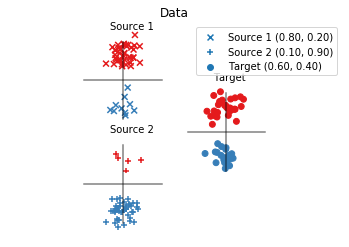

In [5]:
pl.figure(1)
pl.clf()
plot_ax(dec1, 'Source 1')
plot_ax(dec2, 'Source 2')
plot_ax(dect, 'Target')
pl.scatter(xs1[:, 0], xs1[:, 1], c=ys1, s=35, marker='x', cmap='Set1', vmax=9,
           label='Source 1 ({:1.2f}, {:1.2f})'.format(1 - p1, p1))
pl.scatter(xs2[:, 0], xs2[:, 1], c=ys2, s=35, marker='+', cmap='Set1', vmax=9,
           label='Source 2 ({:1.2f}, {:1.2f})'.format(1 - p2, p2))
pl.scatter(xt[:, 0], xt[:, 1], c=yt, s=35, marker='o', cmap='Set1', vmax=9,
           label='Target ({:1.2f}, {:1.2f})'.format(1 - pt, pt))
pl.title('Data')

pl.legend()
pl.axis('equal')
pl.axis('off')

Instantiate Sinkhorn transport algorithm and fit them for all source domains
----------------------------------------------------------------------------



In [6]:
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1, metric='sqeuclidean')


def print_G(G, xs, ys, xt):
    for i in range(G.shape[0]):
        for j in range(G.shape[1]):
            if G[i, j] > 5e-4:
                if ys[i]:
                    c = 'b'
                else:
                    c = 'r'
                pl.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]], c, alpha=.2)

Fig 2 : plot optimal couplings and transported samples
------------------------------------------------------



(-1.85, 5.85, -4.170525419290473, 4.251885380465107)

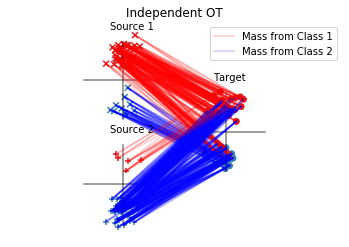

In [7]:
pl.figure(2)
pl.clf()
plot_ax(dec1, 'Source 1')
plot_ax(dec2, 'Source 2')
plot_ax(dect, 'Target')
print_G(ot_sinkhorn.fit(Xs=xs1, Xt=xt).coupling_, xs1, ys1, xt)
print_G(ot_sinkhorn.fit(Xs=xs2, Xt=xt).coupling_, xs2, ys2, xt)
pl.scatter(xs1[:, 0], xs1[:, 1], c=ys1, s=35, marker='x', cmap='Set1', vmax=9)
pl.scatter(xs2[:, 0], xs2[:, 1], c=ys2, s=35, marker='+', cmap='Set1', vmax=9)
pl.scatter(xt[:, 0], xt[:, 1], c=yt, s=35, marker='o', cmap='Set1', vmax=9)

pl.plot([], [], 'r', alpha=.2, label='Mass from Class 1')
pl.plot([], [], 'b', alpha=.2, label='Mass from Class 2')

pl.title('Independent OT')

pl.legend()
pl.axis('equal')
pl.axis('off')

Instantiate JCPOT adaptation algorithm and fit it
----------------------------------------------------------------------------



(-1.85, 5.85, -4.170525419290473, 4.251885380465107)

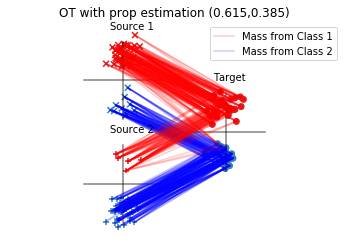

In [8]:
otda = ot.da.JCPOTTransport(reg_e=1, max_iter=1000, metric='sqeuclidean', tol=1e-9, verbose=True, log=True)
otda.fit(all_Xr, all_Yr, xt)

ws1 = otda.proportions_.dot(otda.log_['D2'][0])
ws2 = otda.proportions_.dot(otda.log_['D2'][1])

pl.figure(3)
pl.clf()
plot_ax(dec1, 'Source 1')
plot_ax(dec2, 'Source 2')
plot_ax(dect, 'Target')
print_G(ot.bregman.sinkhorn(ws1, [], otda.log_['M'][0], reg=1e-1), xs1, ys1, xt)
print_G(ot.bregman.sinkhorn(ws2, [], otda.log_['M'][1], reg=1e-1), xs2, ys2, xt)
pl.scatter(xs1[:, 0], xs1[:, 1], c=ys1, s=35, marker='x', cmap='Set1', vmax=9)
pl.scatter(xs2[:, 0], xs2[:, 1], c=ys2, s=35, marker='+', cmap='Set1', vmax=9)
pl.scatter(xt[:, 0], xt[:, 1], c=yt, s=35, marker='o', cmap='Set1', vmax=9)

pl.plot([], [], 'r', alpha=.2, label='Mass from Class 1')
pl.plot([], [], 'b', alpha=.2, label='Mass from Class 2')

pl.title('OT with prop estimation ({:1.3f},{:1.3f})'.format(otda.proportions_[0], otda.proportions_[1]))

pl.legend()
pl.axis('equal')
pl.axis('off')

Run oracle transport algorithm with known proportions
----------------------------------------------------------------------------



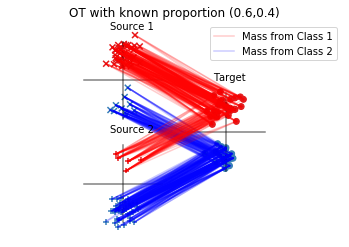

In [9]:
h_res = np.array([1 - pt, pt])

ws1 = h_res.dot(otda.log_['D2'][0])
ws2 = h_res.dot(otda.log_['D2'][1])

pl.figure(4)
pl.clf()
plot_ax(dec1, 'Source 1')
plot_ax(dec2, 'Source 2')
plot_ax(dect, 'Target')
print_G(ot.bregman.sinkhorn(ws1, [], otda.log_['M'][0], reg=1e-1), xs1, ys1, xt)
print_G(ot.bregman.sinkhorn(ws2, [], otda.log_['M'][1], reg=1e-1), xs2, ys2, xt)
pl.scatter(xs1[:, 0], xs1[:, 1], c=ys1, s=35, marker='x', cmap='Set1', vmax=9)
pl.scatter(xs2[:, 0], xs2[:, 1], c=ys2, s=35, marker='+', cmap='Set1', vmax=9)
pl.scatter(xt[:, 0], xt[:, 1], c=yt, s=35, marker='o', cmap='Set1', vmax=9)

pl.plot([], [], 'r', alpha=.2, label='Mass from Class 1')
pl.plot([], [], 'b', alpha=.2, label='Mass from Class 2')

pl.title('OT with known proportion ({:1.1f},{:1.1f})'.format(h_res[0], h_res[1]))

pl.legend()
pl.axis('equal')
pl.axis('off')
pl.show()